# Binary Classification Twitter Sentiment Analysis in Python Using Logistic Regression

In [1]:
# Libraries for Necesary Data Structures
import numpy as np
import pandas as pd
import string
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Natural Language Processing libraries
from wordcloud import WordCloud
from nltk import TweetTokenizer, PorterStemmer
from nltk.corpus import stopwords
# Machine Learning Tools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Quick settings before starting
%matplotlib inline
sns.set_style("white")

### Read in the training dataset as a Pandas DataFrame

In [2]:
df_train = pd.read_csv("data/train_dataset_20k.csv")
df_train.head()

,Sentiment,id,Date,Query,User,Tweet
0,4,2014351367,Wed Jun 03 01:14:33 PDT 2009,NO_QUERY,cathyleehart,@just_tam21 hahah its kind of the same as adel...
1,4,1984531826,Sun May 31 15:17:28 PDT 2009,NO_QUERY,carlawaslike,@Austinjamest sweeeet can't wait to go there w...
2,4,2185079853,Mon Jun 15 16:51:18 PDT 2009,NO_QUERY,Rommellll,You said you changed how wrong i proved you n...
3,4,1998128979,Mon Jun 01 18:02:23 PDT 2009,NO_QUERY,pauljopling,I can't wait for New Moon after seeing the tra...
4,4,2182994010,Mon Jun 15 13:54:26 PDT 2009,NO_QUERY,thisgoodlife,@nicolassa new drum carder? SWEET!


### By default, sentiments are labeled as "4" for positive and "0" for negative. For legibility purposes, I'm adjusting the training dataset by replacing the 4's with 1's, and also by getting rid of unnecessary columns.

In [3]:
df_train = df_train[["Sentiment", "id", "Tweet"]]
df_train.replace(4, 1, inplace=True)
df_train.head()

,Sentiment,id,Tweet
0,1,2014351367,@just_tam21 hahah its kind of the same as adel...
1,1,1984531826,@Austinjamest sweeeet can't wait to go there w...
2,1,2185079853,You said you changed how wrong i proved you n...
3,1,1998128979,I can't wait for New Moon after seeing the tra...
4,1,2182994010,@nicolassa new drum carder? SWEET!


In [4]:
df_train.info()
print(f"\nThere are {df_train.shape[0]:,} rows and {df_train.shape[1]:,} columns in our Tweet Training Set.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  20000 non-null  int64 
 1   id         20000 non-null  int64 
 2   Tweet      20000 non-null  object
dtypes: int64(2), object(1)
memory usage: 468.9+ KB

There are 20,000 rows and 3 columns in our Tweet Training Set.


### To preprocess the tweets in our training dataset, we must do the following:
 1. Remove hyperlinks, punctuation, and hashtags
 2. Transform each Tweet into a list of its individual words
 3. Convert each word to Lower Case
 4. Delete stop words
 5. Stemming to equate words like "eat", "eats", and "eating" all to "eat"

In [5]:
def preprocess_tweets(df):
    """
    The preprocess_tweets() function goes through the following steps:
        1. Remove hyperlinks, punctuation, and hashtags
        2. Transform each Tweet into a list of its individual words
        3. Convert each word to Lower Case
        4. Delete stop words
        5. Stemming to equate words like "eat", "eats", and "eating" all to "eat"

    params:
        df : Pandas Dataframe containing our data

    @RETURN a 2D Python list with columns representing individual words and rows representing
        each individual Tweet
    """
    
    # Replace certain characters in each Tweet with empty spaces instead
    df["Tweet"] = df["Tweet"].str.replace(r"\$\w*", "", regex=True)
    df["Tweet"] = df["Tweet"].str.replace(r"https?:\/\/.*[\r\n]:", "", regex=True)
    df["Tweet"] = df["Tweet"].str.replace(r"http?:\/\/.*[\r\n]:", "", regex=True)
    df["Tweet"] = df["Tweet"].str.replace(r"#", "", regex=True)

    # Initialize a Tweet Tokenizer method that will convert Tweets to lower-case and eliminate Twitter handles
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

    # Make necessary declarations for upcoming 2D for-loop
    m = df.shape[0]
    tokens = []
    stopWords = stopwords.words("english")
    stemmer = PorterStemmer()
    stemmedTweets = []
    myStopWords = {"go", "day"}

    # Tokenize our tweets and insert them into the tokens numpy array
    for i in range(m):
        buffer = []
        tokens.append(tokenizer.tokenize(df.loc[i, "Tweet"]))

        # Remove stop words and words with punctuation 
        for tweet_word in tokens[i]:
            if tweet_word not in stopWords and tweet_word not in string.punctuation and tweet_word not in myStopWords:
                # buffer.append(tweet_word)
                stem_word = stemmer.stem(str(tweet_word))
                buffer.append(stem_word)
            
        # Append the 2D List that we'll be returning with this function
        stemmedTweets.append(buffer)
        

    return stemmedTweets


### Apply the preprocess_tweets() function to return a 2D List containing cleaned tweets

In [6]:
trainingTweets = preprocess_tweets(df_train)

### Create a y-vector that includes all of the true positive and negative classifications for our training data

In [7]:
y_train = []
for i in range(df_train.shape[0]):
    y_train.append(1 if df_train["Sentiment"][i] == 1 else 0)

### Create a dictionary including all of our words and their positive and negative appearance frequencies in the training data

In [8]:
# Append the dictionary Data Structure every time the for loop comes across a new word, and update
# it by either incrementing the positive index [0] or negative index [1], depending on what kind
# of tweet it pops up in
dictionary = {}
for y, tweet in zip(y_train, trainingTweets):
    for token in tweet:
        if token not in dictionary:
            dictionary[token] = [1,0] if y==0 else [0,1]
        elif token in dictionary:
            if y==0:
                dictionary[token][0] += 1
            elif y==1:
                dictionary[token][1] += 1

### Create Positive appearances and Negative appearance lists for training tweets

In [9]:
posTrainingWords = [ trainingTweets[i][j] for i in range(len(trainingTweets)) for j in range(len(trainingTweets[i])) if y_train[i]==1 ]
negTrainingWords = [ trainingTweets[i][j] for i in range(len(trainingTweets)) for j in range(len(trainingTweets[i])) if y_train[i]==0 ]

### Generate Positive and Negative WordCloud to visualize what words commomly pop up in positive and negative tweets

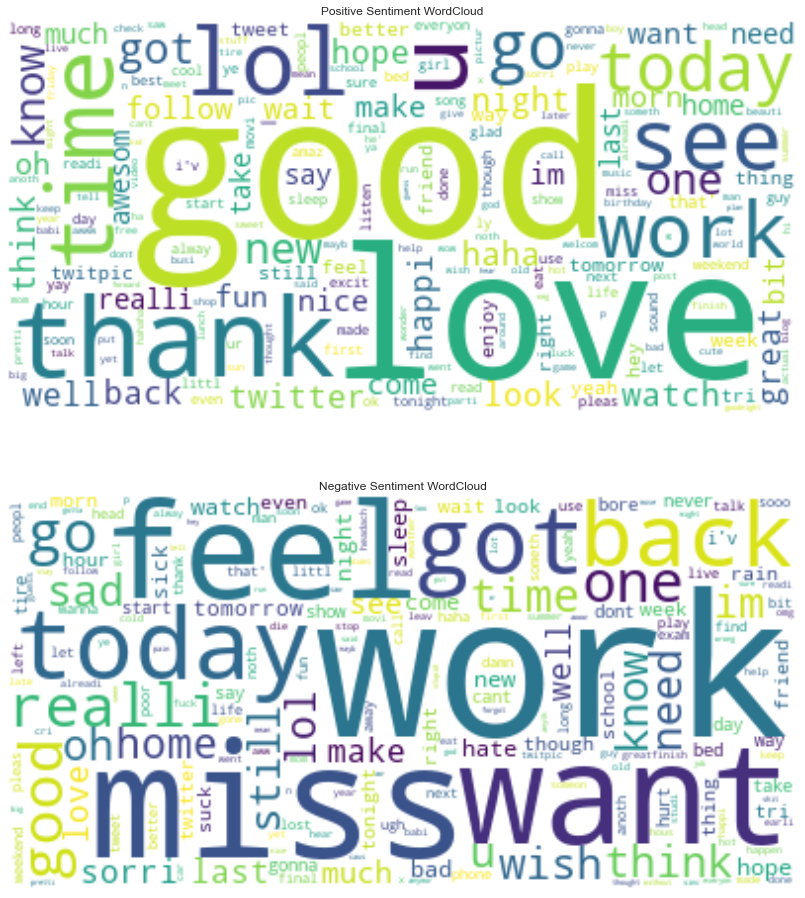

In [10]:
# Create the Word Clouds
pos_word_cloud = WordCloud(collocations=False, background_color="white").generate(",".join(posTrainingWords))
neg_word_cloud = WordCloud(collocations=False, background_color="white").generate(",".join(negTrainingWords))

# Plot the Word Cloud images below
fig, axs = plt.subplots(2, figsize=(28,16))
for ax in axs:
    ax.axis("off")
axs[0].imshow(pos_word_cloud, interpolation="bilinear")
axs[0].set_title("Positive Sentiment WordCloud")
axs[1].imshow(neg_word_cloud, interpolation="bilinear")
axs[1].set_title("Negative Sentiment WordCloud")

plt.show()


### Feature Extraction: Create a (tweetNum) x 3 matrix to represent the following:
#### col[0] : all 1's to take into account a constant in a logistic regression model
#### col[1] : the number of training-set positive appearances for each word in each tweet
#### col[2] : the number of training-set negative appearances for each word in each tweet

In [11]:
def numerical_data(tweets, dictionary=dictionary):
    """
    The numerical_data() function translates tweets to measurable, quantitative data in a 2D matrix
    representing the following:
        column[0] : all 1's to denote where the logistic regression model stands in an empty
                    tweet
        column[1] : the sum of all positive appearances in the entire training set of each word that's
                    located in the tweet being evaluated
        column[2] : the sum of all negative appearances in the entire training set of each word that's
                    located in the tweet being evaluated
    
    params:
        tweets : a 2D-list where the outer elements represent individual tweets and the inner elements 
                 represent individual words within the tweet
        dictionary : a dict-type data structure representing all the words that appear in the training set,
                     as well as their total positive and negative appearances within the training set

    @RETURN a mx3 matrix where m represents the total number of tweets
    """
    
    # m = len(tweets)
    # X = np.zeros((m, 3))

    # for i in range(m):
    #     X[i][0] = 1
    #     for word in tweets[i]:
    #         if word in dictionary:
    #             if dictionary[word][0] > dictionary[word][1]:
    #                 X[i][1] += 1
    #             elif dictionary[word][0] < dictionary[word][1]:
    #                 X[i][2] += 1

    m = len(tweets)
    X = np.zeros((m, 3))

    for i in range(m):
        X[i][0] = 1
        for word in tweets[i]:
            if word in dictionary:
                X[i][1] += dictionary[word][0]
                X[i][2] += dictionary[word][1]


    return X
        

In [12]:
X_train = numerical_data(trainingTweets)

### Load X_train information into the Pandas Dataframe so I can accuractely plot it on a scatterplot with indicated hue

In [13]:
df_train["Positive Appearances"] = pd.Series(X_train[:,1])
df_train["Negative Appearances"] = pd.Series(X_train[:,2])
df_train.head()

,Sentiment,id,Tweet,Positive Appearances,Negative Appearances
0,1,2014351367,@just_tam21 hahah its kind of the same as adel...,134.0,167.0
1,1,1984531826,@Austinjamest sweeeet can't wait to go there w...,1903.0,1498.0
2,1,2185079853,You said you changed how wrong i proved you n...,205.0,170.0
3,1,1998128979,I can't wait for New Moon after seeing the tra...,1065.0,1183.0
4,1,2182994010,@nicolassa new drum carder? SWEET!,223.0,399.0


### Plot the points without the decision boundary to better understand what our logistic regression boundary is doing

/Users/reece/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


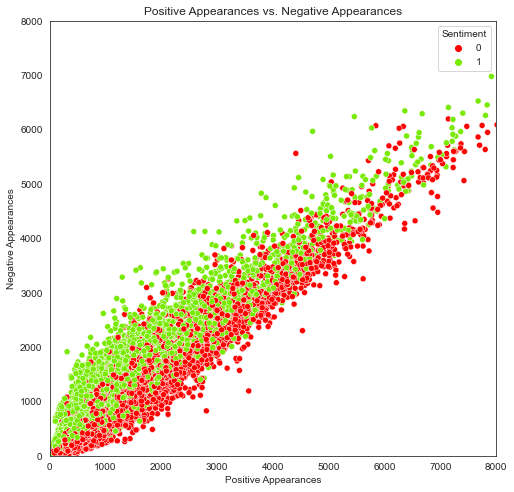

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
colors = ["#FF0000", "#78E900"]
sns.scatterplot("Positive Appearances", "Negative Appearances", data=df_train, hue="Sentiment", palette=colors)
ax.set_xlim([0, 8000])
ax.set_ylim([0, 8000])

ax.set_title("Positive Appearances vs. Negative Appearances")

plt.show()

### Read in the Testing Data and remove irrelevant columns

In [15]:
df_test = pd.read_csv("data/test_dataset_10k.csv")
df_test = df_test[["id", "Tweet"]]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10000 non-null  int64 
 1   Tweet   10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [16]:
df_train.head()

,Sentiment,id,Tweet,Positive Appearances,Negative Appearances
0,1,2014351367,@just_tam21 hahah its kind of the same as adel...,134.0,167.0
1,1,1984531826,@Austinjamest sweeeet can't wait to go there w...,1903.0,1498.0
2,1,2185079853,You said you changed how wrong i proved you n...,205.0,170.0
3,1,1998128979,I can't wait for New Moon after seeing the tra...,1065.0,1183.0
4,1,2182994010,@nicolassa new drum carder? SWEET!,223.0,399.0


In [17]:
df_test.head()

,id,Tweet
0,2002781955,Sitting in the office forced to look at the su...
1,1678880603,Doing absolutely nothing alll weekend. How fun.
2,2243873058,@NatYeates Usually still at work at that time
3,1795044265,"Last night's CM and NY were good, but why Tony..."
4,1957147787,@SafariGuide Many thanks for the #travel #foll...


### Implement the same preprocessing and feature extraction functions for the Testing Data, so we can quantifiably check how it fares with our current Logistic Regression model

In [18]:
testingTweets = preprocess_tweets(df_test)
X_test = numerical_data(testingTweets)

### Get the true sentiments, so we can finally test a Logistic Regression model on our testing data

In [19]:
df_results = pd.read_csv("data/test_dataset_sentiment_10k.csv")
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sentiment  10000 non-null  int64
 1   id         10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


In [20]:
df_results["Sentiment"].replace(4, 1, inplace=True)
y_test = df_results["Sentiment"].to_numpy()

### Use scikit-learn to generate logistic regression parameters, and test our model on the training set

In [21]:
# Create a LogisticRegression() object
logReg = LogisticRegression()

# Fit logistic regression parameters
logReg.fit(X_train, y_train)

# Calculate training accuracy and output it
trainingAccuracy = logReg.score(X_train, y_train)
print(f"The Logistic Regression model has an accuracy of {trainingAccuracy*100:.2f}% against our training data.")

# Calculate y-predictions
y_pred = logReg.predict(X_test)

# Calculate testing accuracy and output it
testingAccuracy = logReg.score(X_test, y_test)
print(f"The Logistic Regression model has an accuracy of {testingAccuracy*100:.2f}% against our testing data.")

The Logistic Regression model has an accuracy of 69.86% against our training data.
The Logistic Regression model has an accuracy of 68.55% against our testing data.


### Graph a confusion matrix to evaluate sensitivity and specificity of the Logistic Regression model

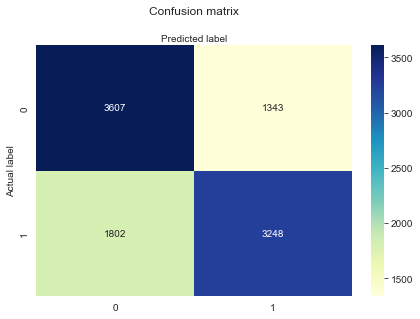

In [22]:
cnf_matrix = confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()

### Obtain parameters for graphing the decision boundary

In [23]:
# Obtain regression parameters
b0, b1, b2 = logReg.coef_[0]

# Calculate intercept and gradient of the decision boundary
c = -b0/b2
m = -b1/b2

# Label graph minimums and maximums
x_min, x_max = [0, 8000]
y_min, y_max = [0, 8000]

# Create xArray plot including information necessary for plotting the decision boundary
xArray = np.array([x_min, x_max])
yArray = m*xArray + c

x_values = np.linspace(0,8000,16000)

### Graph the decision boundary of our Logistic Regression Model on the Training Data

/Users/reece/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


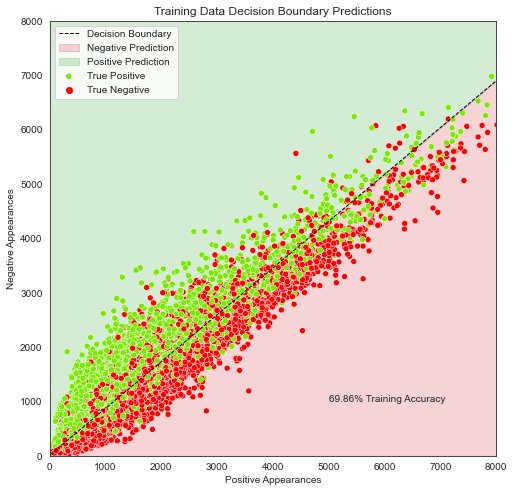

In [24]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(xArray, yArray, 'k', lw=1, ls="--")
ax.fill_between(xArray, yArray, y_min, color="tab:red", alpha=0.2)
ax.fill_between(xArray, yArray, y_max, color="tab:green", alpha=0.2)

colors = ["#FF0000", "#78E900"]
sns.scatterplot("Positive Appearances", "Negative Appearances", data=df_train, hue="Sentiment", palette=colors)
ax.set_xlim([0, 8000])
ax.set_ylim([0, 8000])

ax.text(5000, 1000, f"{trainingAccuracy*100:.2f}% Training Accuracy")

ax.set_title("Training Data Decision Boundary Predictions")
ax.legend(loc="upper left", labels=["Decision Boundary", "Negative Prediction", "Positive Prediction", "True Positive", "True Negative"])

plt.show()

### Input all quantitative data into the df_results Pandas DataFrame

In [25]:
df_results["Positive Appearances"] = pd.Series(X_test[:,1])
df_results["Negative Appearances"] = pd.Series(X_test[:,2])
df_results["Sentiment Predictions"] = pd.Series(y_pred)
df_results.head()

,Sentiment,id,Positive Appearances,Negative Appearances,Sentiment Predictions
0,0,2002781955,745.0,746.0,1
1,1,1678880603,351.0,432.0,1
2,0,2243873058,1487.0,1033.0,0
3,0,1795044265,699.0,1002.0,1
4,1,1957147787,312.0,952.0,1


### Graph the decision boundary of our Logistic Regression Model on the Testing Data

/Users/reece/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


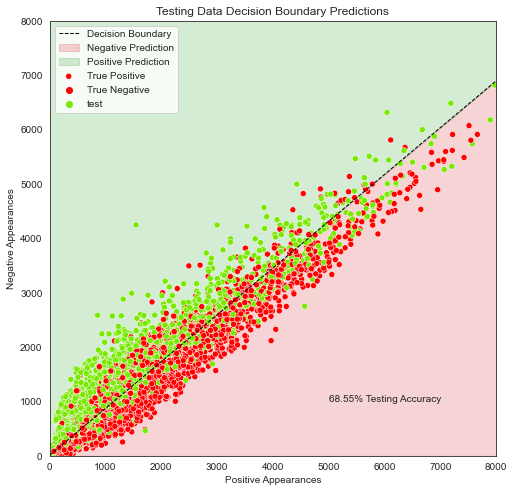

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(xArray, yArray, 'k', lw=1, ls="--")
ax.fill_between(xArray, yArray, y_min, color="tab:red", alpha=0.2)
ax.fill_between(xArray, yArray, y_max, color="tab:green", alpha=0.2)

colors = ["#FF0000", "#78E900"]
sns.scatterplot("Positive Appearances", "Negative Appearances", data=df_results, hue="Sentiment", palette=colors)
ax.set_xlim([0, 8000])
ax.set_ylim([0, 8000])

ax.text(5000, 1000, f"{testingAccuracy*100:.2f}% Testing Accuracy")

ax.set_title("Testing Data Decision Boundary Predictions")
ax.legend(loc="upper left", labels=["Decision Boundary", "Negative Prediction", "Positive Prediction", "True Positive", "True Negative", "test", "test"])

plt.show()